# CMU 10-605/10-805 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel → Restart) and then **run all cells** (in the menubar, select Cell → Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

#CMU 10605/10805 Machine Learning with Large Datasets

## Homework 2 - Part 1:  Linear Regression

In [4]:
# Who did you collaborate with on this assignment? 
# if no one, collaborators should contain an empty string,
# else list your collaborators below

collaborators = [""]
# YOUR CODE HERE
#raise NotImplementedError()

In [5]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")   

In [6]:
# YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext(appName="hw")
sqlContext = SQLContext(sc)

print("spark context started")

# Linear Regression

This section covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.

## This section will cover:
*  *Part 1:* Read and parse the initial dataset
  * *Visualization 1:* Features
  * *Visualization 2:* Shifting labels

*  *Part 2:* Create and evaluate a baseline model
  * *Visualization 3:* Predicted vs. actual

*  *Part 3:* Train (via gradient descent) and evaluate a linear regression model
  * *Visualization 4:* Training error

*  *Part 4:* Train using SparkML and tune hyperparameters via grid search
  * *Visualization 5:* Best model's predictions
  * *Visualization 6:* Hyperparameter heat map

*  *Part 5:* Add interactions between features

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [Spark's RDD Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD), [Spark's DataFrame Python API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) and [Sparks's Row API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Part 1: Read and parse the initial dataset

### (1a) Load and check the data

The raw data is currently stored in text file.  We will start by storing this raw data in as a DataFrame, with each element of the DataFrame representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Your task is to 

1.  Use the DataFrame [count method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.count) to check how many data points we have.  
2. Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.take) to create and print out a list of the first 5 data points in their initial string format.

In [10]:
from pyspark import SparkFiles
url = 'https://raw.githubusercontent.com/10605/data/master/hw2/millionsong.txt'
sc.addFile(url)

# Load the dataset from a file
raw_data_df = sqlContext.read.load("file://" + SparkFiles.get("millionsong.txt"), 'text')

In [11]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
num_points = raw_data_df.count()
print (num_points)
sample_points = raw_data_df.take(5)
print (sample_points)

# YOUR CODE HERE
#raise NotImplementedError()

6724
[Row(value='2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817'), Row(value='2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624'), Row(value='2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818'), Row(value='2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173'), Row(value='2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946')]

In [12]:
# TEST Load and check the data (1a)
from nose.tools import assert_equal, assert_true
assert_equal(num_points, 6724, 'incorrect value for num_points')
assert_equal(len(sample_points), 5, 'incorrect length for sample_points')

### (1b) Using `LabeledPoint`

In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the `parse_points` function that takes, as input, a DataFrame of comma-separated strings. We'll pass it the `raw_data_df` DataFrame.

It should parse each row in the DataFrame into individual elements, using Spark's [select](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select) and [split](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.split) methods.

For example, split `"2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419"` into `['2001.0', '0.884', '0.610', '0.600', '0.474', '0.247', '0.357', '0.344', '0.33', '0.600', '0.425', '0.60', '0.419']`.

The first value in the resulting list (`2001.0` in the example, above) is the label. The remaining values (`0.884`, `0.610`, etc., in the example) are the features.

After splitting each row, map it to a `LabeledPoint`. You'll have to step down to an RDD (using `.rdd`) or use a DataFrame user-defined function to convert to the `LabeledPoint` object. (See **Hint**, below.) If you step down to an RDD, you'll have to use [toDF()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toDF) to convert back to a DataFrame.

Use this new `parse_points` function to parse `raw_data_df`.  Then print out the features and label for the first training point, using the `features` and `label` attributes. Finally, calculate the number of features for this dataset.

## Hint: Running Arbitrary Lambdas on a DataFrame

To solve this problem, you need a way to run your `parse_points` function on a DataFrame. There are two ways to do this, which we will illustrate with an extremely simple example.

Suppose you have a DataFrame consisting of a first name and a last name, and you want to add a unique [SHA-256](https://en.wikipedia.org/wiki/Secure_Hash_Algorithm) hash to each row.

```
df = sqlContext.createDataFrame([("John", "Smith"), ("Ravi", "Singh"), ("Julia", "Jones")], ("first_name", "last_name"))
```

Here's a simple function to calculate such a hash, using Python's built-in `hashlib` library:

```
def make_hash(first_name, last_name):
    import hashlib
    m = hashlib.sha256()
    # Join the first name and last name by a blank and hash the resulting
    # string.
    full_name = ' '.join((first_name, last_name))
    m.update(full_name)
    return m.hexdigest()
```

Okay, that's great. But, how do we use it on our DataFrame? We can use a UDF:

```
from pyspark.sql.functions import udf
u_make_hash = udf(make_hash)
df2 = df.select(df['*'], u_make_hash(df['first_name'], df['last_name']))
# could run df2.show() here to prove it works
```

Or we can step down to an RDD, use a lambda to call `make_hash` and have the lambda return a `Row` object, which Spark can use to ["infer" a new DataFrame](http://spark.apache.org/docs/latest/sql-programming-guide.html#inferring-the-schema-using-reflection).

```
from pyspark.sql import Row
def make_hash_from_row(row):
    hash = make_hash(row[0], row[1])
    return Row(first_name=row[0], last_name=row[1], hash=hash)

df2 = (df.rdd
         .map(lambda row: make_hash_from_row(row))
         .toDF())
```

These methods are roughly equivalent. 

Your task is to use something similar to convert _your_ `raw_data_df` DataFrame into a new DataFrame of `LabeledPoint` objects.

In [14]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [15]:
# TODO: Uncomment and replace <FILL IN> with appropriate code
from pyspark.sql import functions as sql_functions

def parse_points(df):
    """Converts a DataFrame of comma separated unicode strings into a DataFrame of `LabeledPoints`.

    Args:
        df: DataFrame where each row is a comma separated unicode string. The first element in the string
            is the label and the remaining elements are the features.

    Returns:
        DataFrame: Each row is converted into a `LabeledPoint`, which consists of a label and
            features. To convert an RDD to a DataFrame, simply call toDF().
    """
    return df.rdd.map(lambda x:str(x['value']).split(',')).map(lambda x:LabeledPoint(x[0],x[1:])).toDF()

    # YOUR CODE HERE
    #raise NotImplementedError()
    
    
    
parsed_points_df = parse_points(raw_data_df)
first_point_features = parsed_points_df.select('features').rdd.flatMap(list).first()
first_point_label = parsed_points_df.select('label').rdd.flatMap(list).first()
print (first_point_features, first_point_label)

d = len(first_point_features)
print (d)

# YOUR CODE HERE
#raise NotImplementedError()

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12

In [16]:
# TEST Using LabeledPoint (1b)
assert_true(isinstance(first_point_label, float), 'label must be a float')
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
assert_true(np.allclose(expectedX0, first_point_features, 1e-4, 1e-4),
                'incorrect features for firstPointFeatures')

### Visualization 1: Features

First we will load and setup the visualization library. Then we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

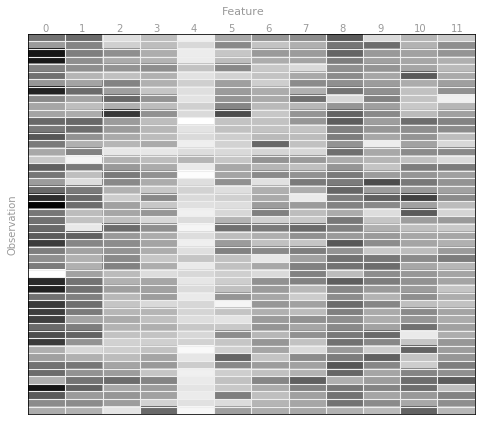

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# takeSample(withReplacement, num, [seed]) randomly selects num elements from the dataset with/without replacement, and has an
# optional seed parameter that one can set for reproducible results

data_values = (parsed_points_df
               .rdd
               .map(lambda lp: lp.features.toArray())
               .takeSample(False, 50, 47))

# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell because there is no set seed.  Note that you should run
# this cell with the line commented out when answering the lab quiz questions.
# data_values = (parsedPointsDF
#                .rdd
#                .map(lambda lp: lp.features.toArray())
#                .takeSample(False, 50))

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = prepare_plot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                       gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(data_values,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
display(fig)

### (1c) Find the range

Now let's examine the labels to find the range of song years. We will use the min and max functions that are native to the DataFrames, and thus can be optimized using Spark's Catalyst Optimizer and Project Tungsten (don't worry about the technical details). This code will run faster than simply using the native min and max functions in Python. 

 Your task is to find the smallest and largest labels in the `parsed_points_df`. Use [selectExpr](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) to retrieve the min and max label values.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
content_stats = (parsed_points_df
                  .selectExpr('min(label)','max(label)')).rdd.flatMap(list).collect()

min_year = content_stats[0]
max_year = content_stats[1]

# YOUR CODE HERE
#raise NotImplementedError()


print (min_year, max_year)


1922.0 2011.0

In [21]:
# TEST Find the range (1c)
assert_equal(len(parsed_points_df.first().features), 12,
                  'unexpected number of features in sample point')
sum_feat_two = parsed_points_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsedPointsDF has unexpected values')
year_range = max_year - min_year
assert_true(year_range == 89, 'incorrect range for minYear to maxYear')

### (1d) Shift labels

As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  

Starting with `parsed_points_df`, create a new DataFrame in which the labels are shifted such that smallest label equals zero (hint: use `select` to select data from the DataFrame). After, use [withColumnRenamed](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed) to rename the appropriate columns to `features` and `label`.

In [23]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
parsed_data_df = parsed_points_df.select('features',parsed_points_df.label-min_year).withColumnRenamed('(label - 1922.0)', 'label')

# # View the first point
print ('\n{0}'.format(parsed_data_df.first()))

# YOUR CODE HERE
#raise NotImplementedError()


Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=79.0)

In [24]:
# TEST Shift labels (1d)
check_column_order = parsed_data_df.columns[0] == 'features'
assert_true(np.allclose(check_column_order, True), 'expected column order should be [features, label]')
old_sample_features = parsed_points_df.first().features
new_sample_features = parsed_data_df.first().features
assert_true(np.allclose(old_sample_features, new_sample_features),
                'new features do not match old features')
sum_feat_two = parsed_data_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsed_data_df has unexpected values')
min_year_new = parsed_data_df.groupBy().min('label').first()[0]
max_year_new = parsed_data_df.groupBy().max('label').first()[0]
assert_true(min_year_new == 0, 'incorrect min year in shifted data')
assert_true(max_year_new == 89, 'incorrect max year in shifted data')

### Visualization 2: Shifting labels

We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing:

* a label value and
* the number of training points with this label.

The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

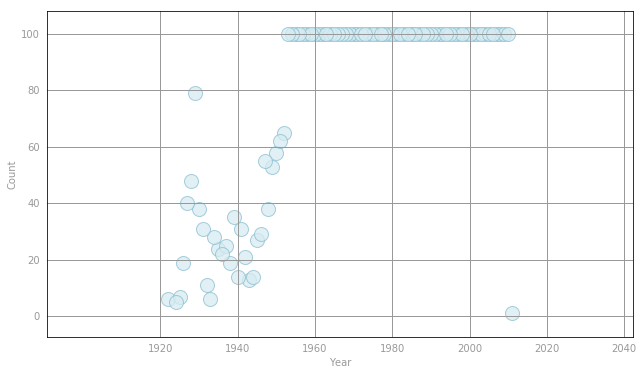

In [26]:
# get data for plot for old data
old_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*old_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
display(fig)

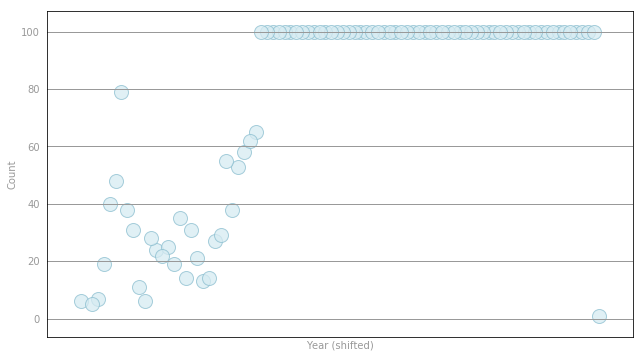

In [27]:
# get data for plot for new data
new_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*new_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
display(fig)
pass

### (1e) Training, validation, and test sets

We're almost done parsing our dataset. 
1. Your final task involves spliting the dataset into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) with the specified weights and seed to create DataFrames storing each of these datasets. 
2. Cache each of these DataFrames, as you will be accessing them multiple times in the remainder of this lab. 
3. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [29]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed)
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()


# YOUR CODE HERE
#raise NotImplementedError()

print (n_train, n_val, n_test, n_train + n_val + n_test)
print (parsed_data_df.count())


5405 644 675 6724
6724

In [30]:
# TEST Training, validation, and test sets (1e)
assert_equal(len(parsed_train_data_df.first().features), 12,
                  'parsed_train_data_df has wrong number of features')
sum_feat_two = (parsed_train_data_df
                 .rdd
                 .map(lambda lp: lp.features[2])
                 .sum())
sum_feat_three = (parsed_val_data_df
                  .rdd
                  .map(lambda lp: lp.features[3])
                  .reduce(lambda x, y: x + y))
sum_feat_four = (parsed_test_data_df
                  .rdd
                  .map(lambda lp: lp.features[4])
                  .reduce(lambda x, y: x + y))
assert_true(np.allclose([sum_feat_two, sum_feat_three, sum_feat_four],
                            2526.87757656, 297.340394298, 184.235876654),
                'parsed Train, Val, Test data has unexpected values')
assert_true(n_train + n_val + n_test == 6724, 'unexpected Train, Val, Test data set size')
assert_equal(n_train, 5405, 'unexpected value for nTrain')
assert_equal(n_val, 644, 'unexpected value for nVal')
assert_equal(n_test, 675, 'unexpected value for nTest')

## Part 2: Create and evaluate a baseline model

### (2a) Average label

A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Your task is to compute this value, which is the average (shifted) song year for the training set.  Use `selectExpr` and `first()` from the [DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) to complete your task.

In [33]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
average_train_year = (parsed_train_data_df
                        .selectExpr('avg(label)')).first()

# YOUR CODE HERE
#raise NotImplementedError()

print (average_train_year)

Row(avg(label)=53.68140610545791)

In [34]:
# TEST Average label (2a)
assert_true(np.allclose(average_train_year, 53.68140610545791),
                'incorrect value for average_train_year')

### (2b) Root mean squared error

We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Using [Regression Evaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator), your task is to compute the RMSE given a dataset of _(prediction, label)_ tuples.

In [36]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
from pyspark.ml.evaluation import RegressionEvaluator

preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])


evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName='rmse')
# YOUR CODE HERE
#raise NotImplementedError()

def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return evaluator.evaluate(dataset)
    # YOUR CODE HERE
    #raise NotImplementedError()

example_rmse = calc_RMSE(preds_and_labels_df)
print (example_rmse)
# RMSE = sqrt[((1-3)^2 + (2-1)^2 + (2-2)^2) / 3] = 1.291


1.2909944487358058

In [37]:
# TEST Root mean squared error (2b)
assert_true(np.allclose(example_rmse, 1.29099444874), 'incorrect value for RMSE')

### (2c) Training, validation and test RMSE

Now let's calculate the training, validation and test RMSE of our baseline model. To do this, you should create DataFrames of _(prediction, label)_ tuples for each dataset, and then call `calc_RMSE()`. 

Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years). You can use [createDataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.createDataFrame) to create a DataFrame with the column names "prediction" and "label" from an RDD.

In [39]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda x:(average_train_year['avg(label)'],x['label']))
preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = parsed_val_data_df.rdd.map(lambda x:(average_train_year['avg(label)'],x['label']))
preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, ["prediction", "label"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

preds_and_labels_test = parsed_test_data_df.rdd.map(lambda x:(average_train_year['avg(label)'],x['label']))
preds_and_labels_test_df = sqlContext.createDataFrame(preds_and_labels_test, ["prediction", "label"])
rmse_test_base = calc_RMSE(preds_and_labels_test_df)



# YOUR CODE HERE
#raise NotImplementedError()

print ('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print ('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))


Baseline Train RMSE = 21.477
Baseline Validation RMSE = 21.227
Baseline Test RMSE = 21.127

In [40]:
# TEST Training, validation and test RMSE (2c)
assert_true(np.allclose([rmse_train_base, rmse_val_base, rmse_test_base],
                            [21.477279181895707, 21.22695358728026, 21.127323734084705]), 'incorrect RMSE values')

### Visualization 3: Predicted vs. actual

We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `average_train_year`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

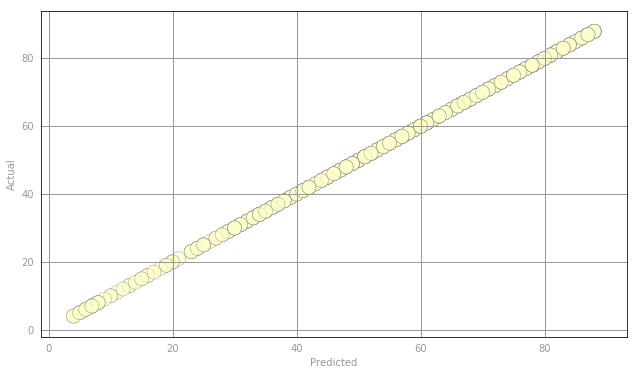

In [42]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squared_error(lp))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

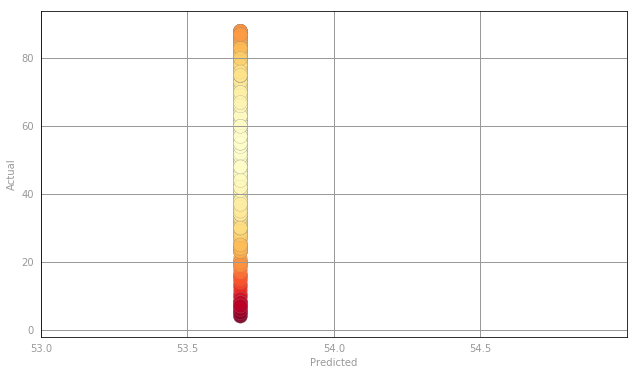

In [43]:
def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_year['avg(label)'])
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, average_train_year['avg(label)']))
                   .map(lambda lp: squared_error(lp))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

## Part 3: Train (via gradient descent) and evaluate a linear regression model

### (3a) Gradient summand

Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is:
\\[ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.\\]
where \\( \scriptsize i \\) is the iteration number of the gradient descent algorithm, \\( \scriptsize j \\) identifies the observation, \\( \scriptsize \alpha \\) is the learning rate

First, implement a function that computes the summand for this update, i.e., the summand equals \\( \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,\\) and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [46]:
from pyspark.mllib.linalg import DenseVector

In [47]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (np.dot(weights.T,lp.features)-lp.label)*lp.features
    # YOUR CODE HERE
    #raise NotImplementedError()

example_w = DenseVector([1, 1, 1])
example_lp = LabeledPoint(2.0, [3, 1, 4])
# gradient_summand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summand_one = gradient_summand(example_w, example_lp)
print (summand_one)

example_w = DenseVector([.24, 1.2, -1.4])
example_lp = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summand_two = gradient_summand(example_w, example_lp)
print (summand_two)


[18.0,6.0,24.0]
[1.7304000000000002,-5.191200000000001,-2.5956000000000006]

In [48]:
# TEST Gradient summand (3a)
assert_true(np.allclose(summand_one, [18., 6., 24.]), 'incorrect value for summand_one')

### (3b) Use weights to make predictions

Next, implement a `get_labeled_predictions` function that takes in weights and an observation's `LabeledPoint` and returns a _(prediction, label)_ tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [50]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (prediction, label) tuple. Convert the return type of the label and prediction to a float.
    """
    return (float(np.dot(weights.T,observation.features)),float(observation.label))
    # YOUR CODE HERE
    #raise NotImplementedError()


weights = np.array([1.0, 1.5])
prediction_example = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                     LabeledPoint(1.5, np.array([.5, .5]))])
preds_and_labels_example = prediction_example.map(lambda lp: get_labeled_prediction(weights, lp))
print (preds_and_labels_example.collect())





[(1.75, 2.0), (1.25, 1.5)]

In [51]:
# TEST Use weights to make predictions (3b)
assert_true(isinstance(preds_and_labels_example.first()[0], float), 'prediction must be a float')
assert_equal(preds_and_labels_example.collect(), [(1.75, 2.0), (1.25, 1.5)],
                  'incorrect definition for getLabeledPredictions')

### (3c) Gradient descent

Next, implement a gradient descent function for linear regression and test out this function on an example.

In [53]:
# TODO: Uncomment the follosing lines and replace <FILL IN> with appropriate code
def linreg_gradient_descent(train_data, num_iters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        train_data (RDD of LabeledPoint): The labeled data for use in training the model.
        num_iters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = train_data.count()
    # The number of features in the training data
    d = len(train_data.first().features)
    w = np.zeros(d)
    # learning rate
    alpha = 1.0
    # You will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
#        # Use get_labeled_prediction from (3b) with trainData to obtain an RDD of (label, prediction)
#        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
#        # have large errors to start.
         preds_and_labels_train = train_data.map(lambda x: get_labeled_prediction(w, x))
        
         preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
         error_train[i] = calc_RMSE(preds_and_labels_train_df)

#        # Calculate the `gradient`.  Make use of the `gradient_summand` function you wrote in (3a).
#        # Note that `gradient` should be a `DenseVector` of length `d`.
         gradient = train_data.map(lambda x:gradient_summand(w, x)).sum()

#        # Update the weights
         alpha_i = alpha / (n * np.sqrt(i+1))
         w -= alpha_i*gradient
    return w, error_train
  
    # YOUR CODE HERE
    #raise NotImplementedError()

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linreg_gradient_descent is working properly
example_n = 10 # data points
example_d = 3  # features
example_data = (sc
                 .parallelize(parsed_train_data_df.take(example_n))
                 .map(lambda lp: LabeledPoint(lp.label, lp.features[0:example_d])))
print (example_data.take(2))
example_num_iters = 5
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters)
print (example_weights)


[LabeledPoint(59.0, [0.0,0.696269780071,0.395207288435]), LabeledPoint(35.0, [0.0305925311676,0.402530811194,0.296196625953])]
[ 3.6706757 28.77277769 17.91957382]

In [54]:
# TEST Gradient descent (3c)

expected_output = [ 3.6706757 , 28.77277769, 17.91957382]
assert_true(np.allclose(example_weights, expected_output), 'value of example_weights is incorrect')
expected_error = [38.71433843 ,32.45595388, 30.22343598, 29.10818648, 28.46448674]
assert_true(np.allclose(example_error_train, expected_error),
                'value of exampleErrorTrain is incorrect')

### (3d) Train the model

Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [56]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
num_iters = 50
weights_LR0, error_train_LR0 = linreg_gradient_descent(parsed_train_data_df.rdd, num_iters)

preds_and_labels = (parsed_val_data_df
                       .rdd.map(lambda x: get_labeled_prediction(weights_LR0, x)))
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])
rmse_val_LR0 = calc_RMSE(preds_and_labels_df)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmse_val_base,
                                                                        rmse_val_LR0))

# YOUR CODE HERE
#raise NotImplementedError()


Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776

In [57]:
# TEST Train the model (3d)
expected_output =[22.49753756, 20.37597243, -0.27251763,  8.31521579,  5.88853769, -4.82949119,
                   15.60187764,  3.97275651,  9.93959836,  6.06173598, 10.9900427,   3.72333163]
assert_true(np.allclose(weights_LR0, expected_output), 'incorrect value for weights_LR0')

### Visualization 4: Training error

We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

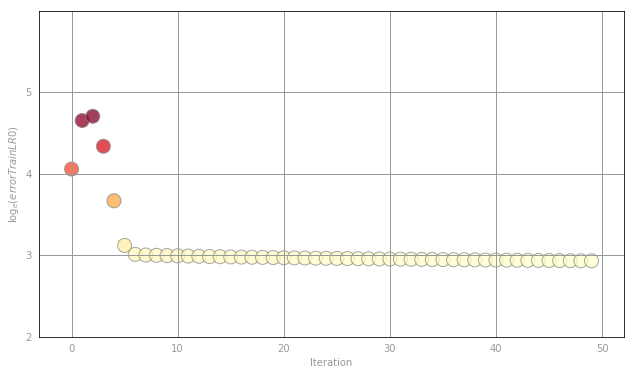

In [59]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_train_LR0))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, num_iters), np.log(error_train_LR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
display(fig)

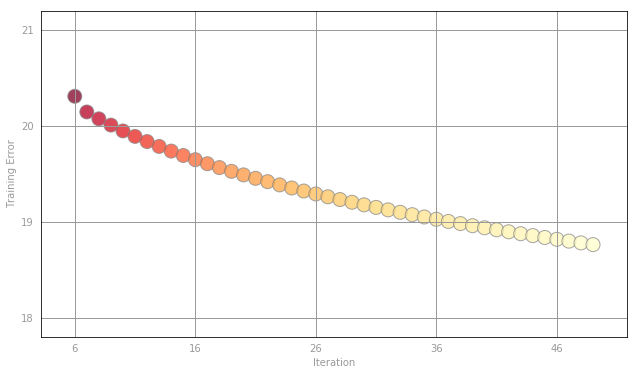

In [60]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_train_LR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, num_iters-6), error_train_LR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
display(fig)

## Part 4: Train using SparkML and perform grid search

### (4a) `LinearRegression`
We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations. MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) essentially applys same idea that we used in Part (3b), albeit using stochastic gradient approximation and more efficiently with various additional functionality including an intercept in the model and also allowing L1 or L2 regularization.

First use [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) to train a model with L2 regularization and with an intercept. This method returns a LinearRegressionModel. Next, use the model's weights (ex model.weights) and intercept (ex model.intercept) attributes to print out the model's parameters

In [63]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [64]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code

# # The data parameter takes in the training data that is an RDD of LabeledPoint. 
# # You may want to transform parsed_train_data_df to required type via map.
first_model = LinearRegressionWithSGD.train(data=parsed_train_data_df.rdd.map(lambda x:LabeledPoint(x.label,x.features)), 
                                            iterations=numIters, 
                                            step=alpha, 
                                            miniBatchFraction=miniBatchFrac, 
                                            initialWeights=None, 
                                            regParam=reg, 
                                            regType=regType, 
                                            intercept=useIntercept 
                                            )

# # coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept
coeffs_LR1 = first_model.weights
intercept_LR1 = first_model.intercept
print (coeffs_LR1, intercept_LR1)


# YOUR CODE HERE
#raise NotImplementedError()


[15.90811601077196,14.141747071778694,0.6361803544493579,6.1325094710269825,3.974387960587376,-2.5115097734889575,10.55122835853148,3.108716057088987,7.247819807528351,4.703102469082578,7.760457489026197,3.0765704673716043] 13.272917647663501

In [65]:
# TEST LinearRegression (4a)
expected_intercept = 13.272917647663501
expected_weights= [15.90811601077196,14.141747071778694,0.6361803544493579,6.1325094710269825,3.974387960587376,-2.5115097734889575,10.55122835853148,3.108716057088987,7.247819807528351,4.703102469082578,7.760457489026197,3.0765704673716043]

assert_true(np.allclose(intercept_LR1, expected_intercept), 'incorrect value for intercept_LR1')
assert_true(np.allclose(coeffs_LR1, expected_weights), 'incorrect value for weights_LR1')

### (4b) Predict

Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point. Pass the features from a LabeledPoint into the predict() method

In [67]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
samplePoint = parsed_train_data_df.take(1)[0]
sample_prediction = first_model.predict(samplePoint[0])
print (sample_prediction)

# YOUR CODE HERE
#raise NotImplementedError()


39.82206386491484

In [68]:
# TEST Predict (4b)
assert_true(np.allclose(sample_prediction, 39.82206386491484),
                'incorrect value for sample_prediction')

### (4c) Evaluate RMSE

Next evaluate the accuracy of this model on the validation set.  First, map [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method on features in parsed_val_data_df to get labelsAndPreds. Create a dataframe based on that and then use the `calc_RMSE()` function from Part (2b).

In [70]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(first_model.predict(lp.features))))
    
labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])

rmse_val_LR1 = calc_RMSE(labels_and_preds_df)

# YOUR CODE HERE
#raise NotImplementedError()


print(rmse_val_LR1)



19.494522647472493

In [71]:
# TEST Evaluate RMSE (4c)
assert_true(np.allclose(rmse_val_LR1, 19.49452264747249), 'incorrect value for rmseValLR1')

### (4d) Grid search

We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1.0`.

In [73]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model
regType = 'l2'  # regType
useIntercept = True  # intercept
num_iters = 500  # iterations
alpha = 1.0 # step
miniBatchFrac = 1.0

for reg in [1e-10,1e-5,1.0]:
    model = LinearRegressionWithSGD.train(data=parsed_train_data_df.rdd.map(lambda x:LabeledPoint(x.label,x.features)),
                                          iterations=num_iters, 
                                          step=alpha, 
                                          miniBatchFraction=miniBatchFrac, 
                                          initialWeights=None, 
                                          regParam=reg, 
                                          regType=regType, 
                                          intercept=useIntercept 
                                         )

    labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(model.predict(lp.features))))
    
    labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])
    rmse_val_grid = calc_RMSE(labels_and_preds_df)
    print (rmse_val_grid)

    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

rmse_val_LR_grid = best_RMSE

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
        '\tLRGrid = {3:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1, rmse_val_LR_grid))

# YOUR CODE HERE
#raise NotImplementedError()


17.19165402610348
17.191959711700587
23.647619626519848
Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 19.495
	LRGrid = 17.192

In [74]:
# TEST Grid search (4d)
assert_true(np.allclose(17.19165402610348, rmse_val_LR_grid), 'incorrect value for rmseValLRGrid')

### Visualization 5: Best model's predictions

Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 2 using the predictions from the best model from Part (4d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

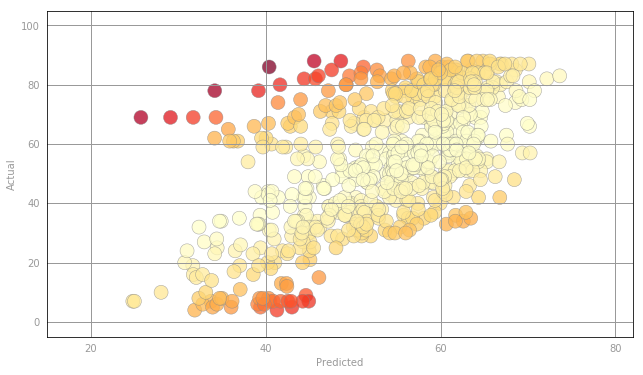

In [76]:
predictions = np.asarray(parsed_val_data_df.rdd
                         .map(lambda lp: best_model.predict(lp.features))
                         .collect())
actual = np.asarray(parsed_val_data_df.rdd
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsed_val_data_df.rdd
                   .map(lambda lp: (lp.label, best_model.predict(lp.features)))
                   .map( lambda lp: squared_error(lp))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
display(fig) 
pass



### Visualization 6: Hyperparameter heat map

Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

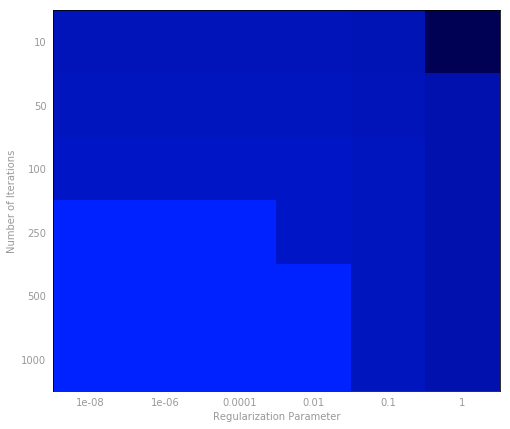

In [78]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 

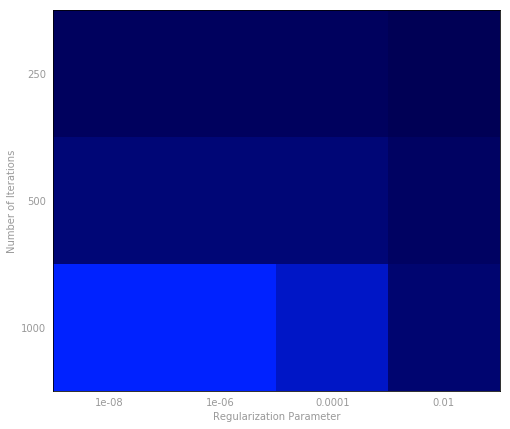

In [79]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 
pass

## Part 5: Add interactions between features

### (5a) Add 2-way interactions

So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `two_way_interactions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.

> Note:
> * A dataset with three features would have nine ( \\( \scriptsize 3^2 \\) ) two-way interactions.
> * You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.
> * Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [82]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
import itertools

def two_way_interactions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    a = []
    for i in itertools.product(lp.features,lp.features):
        a.append((i[0]*i[1]))
    
    return LabeledPoint(lp.label, np.hstack((lp.features,np.array(a))))
    # YOUR CODE HERE
    #raise NotImplementedError()

print (two_way_interactions(LabeledPoint(0.0, [2, 3])))

# # Transform the existing train, validation, and test sets to include two-way interactions.
# # Remember to convert them back to DataFrames at the end.
train_data_interact_df = parsed_train_data_df.rdd.map(lambda x:two_way_interactions(LabeledPoint(x.label,x.features))).toDF()
val_data_interact_df = parsed_val_data_df.rdd.map(lambda x:two_way_interactions(LabeledPoint(x.label,x.features))).toDF()
test_data_interact_df = parsed_test_data_df.rdd.map(lambda x:two_way_interactions(LabeledPoint(x.label,x.features))).toDF()

# YOUR CODE HERE
#raise NotImplementedError()


(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])

In [83]:
# TEST Add two-way interactions (5a)
two_way_example = two_way_interactions(LabeledPoint(0.0, [2, 3]))

assert_true(np.allclose(sorted(two_way_example.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy two_way_interactions')

two_way_point = two_way_interactions(LabeledPoint(1.0, [1, 2, 3]))

assert_true(np.allclose(sorted(two_way_point.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')


assert_equal(two_way_point.label, 1.0, 'incorrect label generated by two_way_interactions')


### (5b) Build interaction model

Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.

 > Note:
 > * Remember that we should build our model from the training data and evaluate it on the validation data.
 > * You should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.
 > * For this exercise, we have already preset the hyperparameters to reasonable values.

In [85]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10


model_interact = LinearRegressionWithSGD.train(data=train_data_interact_df.rdd.map(lambda x:LabeledPoint(x.label,x.features)),
                                          iterations=numIters, 
                                          step=alpha, 
                                          miniBatchFraction=miniBatchFrac, 
                                          initialWeights=None, 
                                          regParam=reg, 
                                          regType='l2', 
                                          intercept=True
                                         )
labels_and_preds_interact = val_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features))))
labels_and_preds_interact_df = sqlContext.createDataFrame(labels_and_preds_interact, ["label", "prediction"])
rmse_val_interact = calc_RMSE(labels_and_preds_interact_df)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
        '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1,
                                                  rmse_val_LR_grid, rmse_val_interact))

# YOUR CODE HERE
#raise NotImplementedError()


Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 19.495
	LRGrid = 17.192
	LRInteract = 16.198

In [86]:
# TEST Build interaction model (5b)
assert_true(np.allclose(rmse_val_interact, 16.197614458395268), 'incorrect value for rmse_val_interact')

### (5c) Evaluate interaction model on test data

Our next step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.

We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [88]:
# TODO: Uncomment following lines and replace <FILL IN> with appropriate code

labels_and_preds_interact_test = test_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features))))
labels_and_preds_interact_test_df = sqlContext.createDataFrame(labels_and_preds_interact_test, ["label", "prediction"])
rmse_test_interact = calc_RMSE(labels_and_preds_interact_test_df)

print (('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
        .format(rmse_test_base, rmse_test_interact)))

#YOUR CODE HERE
#raise NotImplementedError()


Test RMSE:
	Baseline = 21.127
	LRInteract = 16.605

In [89]:
# TEST Evaluate interaction model on test data (5c)
assert_true(np.allclose(rmse_test_interact, 16.605307423246618),
                'incorrect value for rmse_test_interact')